# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

1. [Откроем файл с данными и изучим общую информацию](#start)
2. [Выполним предобработку данных](#preprocessing)
    * [Обработаем явные дубликаты и пропущенные значения в столбцах](#skip)
    * [Рассмотрим типы данных в каждом столбце](#type)
    * [Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты](#uniq)
    * [Найдём и устраним редкие и выбивающиеся значения](#rare)
3. [Добавим в таблицу новые столбцы](#new_column)
4. [Проведём исследовательский анализ данных:](#analys)
    * [Изучим основные параметры объектов](#basic)
    * [Изучим, как быстро продавались квартиры](#speed)
    * [Изучим, от каких параметров зависит цена](#addiction)
    * [Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений](#mean_meter)
    * [Вычислим среднюю цену каждого километра в Санкт-Петербурге](#mean_price)
5. [Общий вывод](#conclusion)

<a id="start">
    
## Откроем файл с данными и изучим общую информацию </a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:,.2f}'.format)

try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

При запуске метода 'info()' была обнаружена проблема. Все данные склеились в одну строку. Разбили их по колонкам параметром 'sep'.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


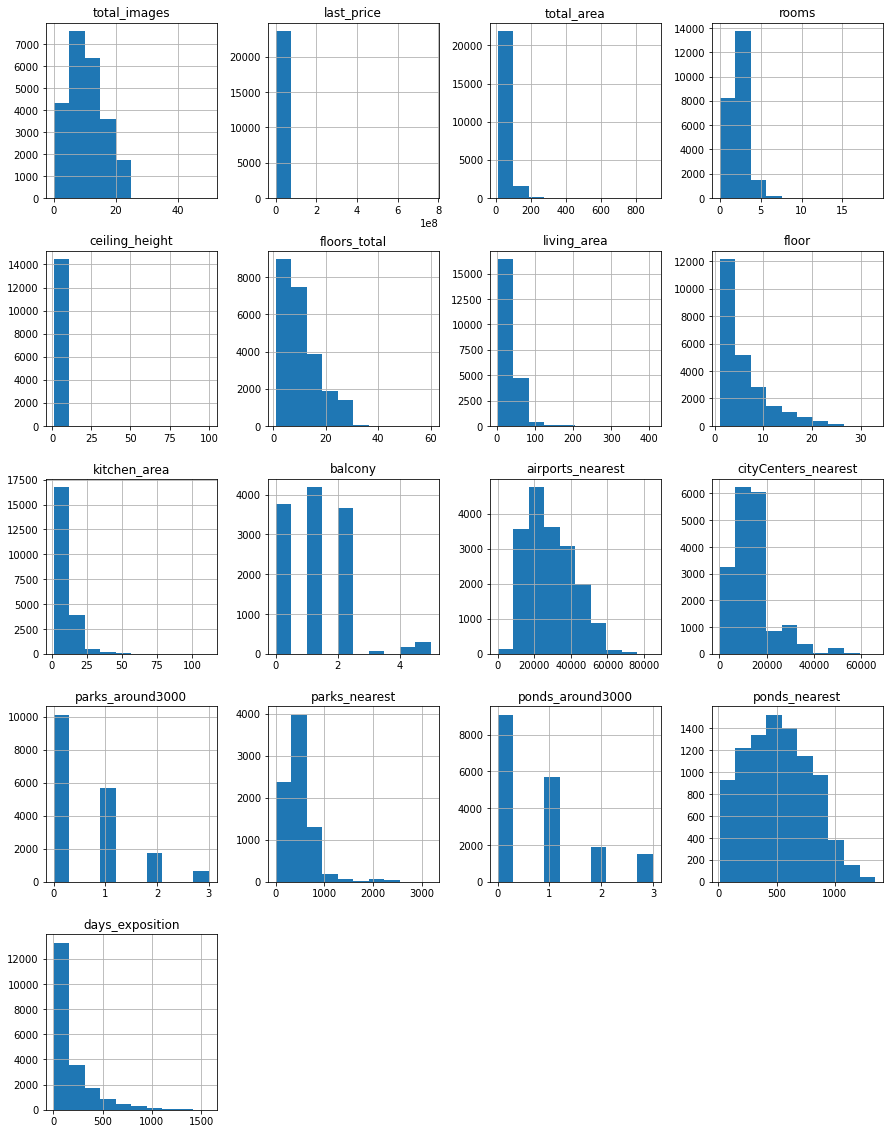

In [ ]:
df.hist(figsize=(15, 20));

На ряде гистограмм наблюдается концентрация значений в левой части и жирные хвосты в правой части таблиц. Требуется очистка от выбросов.

<a id="preprocessing">
    
 ## Выполним предобработку данных

</a>

<a id="skip">

**Обработаем явные дубликаты и пропущенные значения в столбцах**
</a>

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().mean()

total_images           0.00
last_price             0.00
total_area             0.00
first_day_exposition   0.00
rooms                  0.00
ceiling_height         0.39
floors_total           0.00
living_area            0.08
floor                  0.00
is_apartment           0.88
studio                 0.00
open_plan              0.00
kitchen_area           0.10
balcony                0.49
locality_name          0.00
airports_nearest       0.23
cityCenters_nearest    0.23
parks_around3000       0.23
parks_nearest          0.66
ponds_around3000       0.23
ponds_nearest          0.62
days_exposition        0.13
dtype: float64

Заполним пропуски в некоторых столбцах. В столбцах с категориальной переменной пропуски заменим на 'нет данных'. С непрерывной переменной - '55555'. Эти записи - заглушки. Их можно будет в любой момент отсечь, но так мы не потеряем другие важные данные, которые, возможно, хранятся в строках с заглушками. 

В столбце с количеством балконов пропуски, вероятнее всего, возникли из-за того, что балконы в данных квартирах отсутствуют. Заменим пропуски на 0. 

Пропуски в столбце с высотой потолков заменим на медианное значение. Пропуски в столбцaх с площадью кухни и жилой площадью, а также числом этажей заменим на коэффициент (отношение средних показателей столбца с пропусками к среднему показателю пропорционального столбца), помноженный на значение из пропорционального столбца для данной квартиры. 

Столбцы с числом парков и водоемов в радиусе трех километров, а также ближайших водоемов оставим бетз изменений. Для дальнейшего исследования они не понядобятся.

In [ ]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})
df['city_centers_nearest'] = df['city_centers_nearest'].fillna(55555)
df['locality_name'] = df['locality_name'].fillna('нет данных')
df['airports_nearest'] = df['airports_nearest'].fillna(55555)
df['days_exposition'] = df['days_exposition'].fillna(55555)
df['parks_nearest'] = df['parks_nearest'].fillna(55555)

df['balcony'] = df['balcony'].fillna(0)

df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median()) 


df['living_area'] = df['living_area'].fillna((df[df['living_area'].isna() == False]['living_area'].mean() /
                                              df[df['living_area'].isna() == False]['total_area'].mean()) * df['total_area'])
df['kitchen_area'] = df['kitchen_area'].fillna((df[df['kitchen_area'].isna() == False]['kitchen_area'].mean() /
                                              df[df['kitchen_area'].isna() == False]['total_area'].mean()) * df['total_area'])
df['floors_total'] = df['floors_total'].fillna((df[df['floors_total'].isna() == False]['floors_total'].mean() /
                                              df[df['floors_total'].isna() == False]['floor'].mean()) * df['floor'])

df.isna().mean()

total_images           0.00
last_price             0.00
total_area             0.00
first_day_exposition   0.00
rooms                  0.00
ceiling_height         0.00
floors_total           0.00
living_area            0.00
floor                  0.00
is_apartment           0.88
studio                 0.00
open_plan              0.00
kitchen_area           0.00
balcony                0.00
locality_name          0.00
airports_nearest       0.00
city_centers_nearest   0.00
parks_around3000       0.23
parks_nearest          0.00
ponds_around3000       0.23
ponds_nearest          0.62
days_exposition        0.00
dtype: float64

Причины пропуска данных могут быть следующие:

1. Неправильная выгрузка данных.
2. Нежелание авторов объявлений указывать незначительные с их точки зрения параметры, а также параметры, информацией о которых эти авторы не обладают. Например, не все знают высоту потолков в своих квартирах. Еще есть те, кто не хочет акцентировать внимание на малой площади, например, кухни, и не указывают такие сведения.
3. Неверно указан тип данных.
4. Пропуски в картографических данных могут свидетельствовать об ошибках в работе картографических сервисов.

<a id="type">

**Рассмотрим типы данных в каждом столбце**</a>

In [ ]:
df['first_day_exposition'] = df['first_day_exposition'].astype('datetime64')
df['is_apartment'] = df['is_apartment'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Дату публикации перевели из типа 'object' в "рабочий" временной тип. Столбец 'is_apartment' перевели в булев тип, так как в нем содержатся булевы значение - аппартамент: "да" или "нет". Так мы избавились от пропусков в столбце 'is_apartment'.  

<a id="uniq">
    
**Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты**
</a>

In [ ]:
df['locality_name'].value_counts().head(20)

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
Колпино                      338
посёлок Парголово            327
Гатчина                      307
деревня Кудрово              299
Выборг                       237
Петергоф                     201
Сестрорецк                   183
Красное Село                 178
Кудрово                      173
деревня Новое Девяткино      144
Сертолово                    142
Ломоносов                    133
Кириши                       125
Сланцы                       112
Волхов                       111
Name: locality_name, dtype: int64

In [ ]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [ ]:
df['locality_name']=df['locality_name'].replace('Мурино', 'посёлок Мурино')
df['locality_name']=df['locality_name'].replace('Кудрово', 'деревня Кудрово')
df['locality_name']=df['locality_name'].str.replace('поселок', 'посёлок')
df['locality_name'].value_counts().head(20)

Санкт-Петербург            15721
посёлок Мурино               590
деревня Кудрово              472
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
Колпино                      338
посёлок Парголово            327
Гатчина                      307
Выборг                       237
Петергоф                     201
Сестрорецк                   183
Красное Село                 178
деревня Новое Девяткино      144
Сертолово                    142
Ломоносов                    133
Кириши                       125
посёлок Бугры                114
Сланцы                       112
Волхов                       111
Name: locality_name, dtype: int64

Обощать топонимы далее не видим необходимости. После устранения неявных дубликатов деревня Кудрово стала третей в списке населенных пунктов по объему объявлений о продаже жилья, однако двадцатка населённых пунктов - лидеров не изменилась. Да, в столбце есть, например, садовое товарищество Рахья и посёлок городского типа Рахья. Возможно, это дубликаты, но возможно, и нет. Доля таких объявлений не повлияет на дальнейшее исследование.

<a id="rare">

**Найдём и устраним редкие и выбивающиеся значения** 
    </a>

In [ ]:
df['ceiling_height'].unique()

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

In [ ]:
df['ceiling_height'] = df['ceiling_height'].replace({25.: 2.5, 32.: 3.2, 24.  : 2.4, 27.: 2.7, 26.: 2.6, 20.: 2.0, 22.6: 2.26, 27.5: 2.75})
df = df[df['ceiling_height'] < 100]
df['ceiling_height'].describe()

count   23,698.00
mean         2.70
std          0.25
min          1.00
25%          2.60
50%          2.65
75%          2.70
max         14.00
Name: ceiling_height, dtype: float64

Проанализируем значения в столбцах с непрерывными переменными, которые понадобятся нам в работе, на предмет аномалий. Для ряда столбцов, по которым возникнет необходимость уточнения, построим гистограммы.

In [ ]:
df[['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
'kitchen_area', 'balcony', 'days_exposition', 'rooms']].describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,days_exposition,rooms
count,"23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00","23,698.00"
mean,"6,541,191.84",60.35,2.07,2.70,10.70,34.61,5.89,10.50,0.59,"7,613.80",2.07
std,"10,887,104.31",35.65,1.08,0.25,6.64,22.37,4.89,6.04,0.96,"18,878.54",1.08
min,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,1.00,0.00
25%,"3,400,000.00",40.00,1.00,2.60,5.00,19.00,2.00,7.00,0.00,45.00,1.00
50%,"4,650,000.00",52.00,2.00,2.65,9.00,30.00,4.00,9.00,0.00,124.00,2.00
75%,"6,799,750.00",69.90,3.00,2.70,16.00,42.10,8.00,12.00,1.00,390.00,3.00
max,"763,000,000.00",900.00,19.00,14.00,60.00,409.70,33.00,112.00,5.00,"55,555.00",19.00


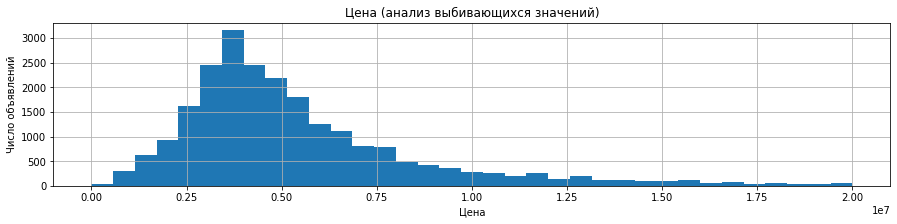

In [ ]:
df['last_price'].plot(kind='hist', bins=35, range = (0, 20000000), grid=True, figsize=(15, 3))
plt.title('Цена (анализ выбивающихся значений)')
plt.xlabel('Цена')
plt.ylabel('Число объявлений');

Наблюдается жирный хвост из объектов недвижимости дороже 300 млн рублей. Эта стоимость сильно отличается от средней стоимости других объектов. Исключим их из исследования.

In [ ]:
df = df[df['last_price'] < 3e8].copy()

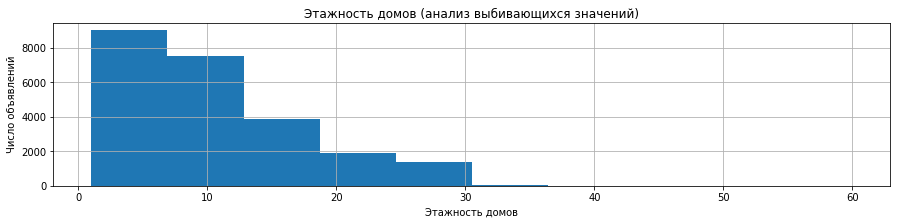

In [ ]:
df['floors_total'].plot(kind='hist', grid=True, figsize=(15, 3))
plt.title('Этажность домов (анализ выбивающихся значений)')
plt.xlabel('Этажность домов')
plt.ylabel('Число объявлений');

На гистограмме виден хвост из значений более 40 этажей. Между тем, максимальная этажность жилого здания в Санкт-Петербурге - 36 этажей. Подрежем верхнее значение.

In [ ]:
df = df[df['floors_total'] < 40].copy()

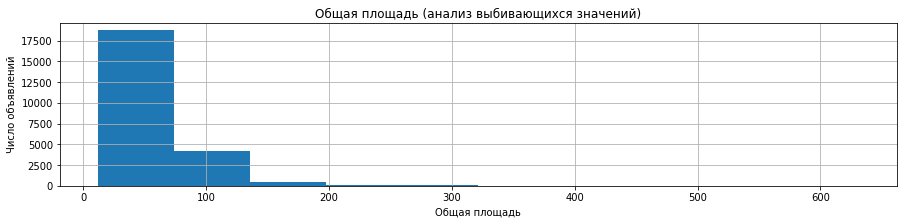

In [ ]:
df['total_area'].plot(kind='hist', grid=True, figsize=(15, 3))
plt.title('Общая площадь (анализ выбивающихся значений)')
plt.xlabel('Общая площадь')
plt.ylabel('Число объявлений');

Аналогичная ситуация с общей площадью. Снова несколько сверхъбольших значений, есть даже квартиры в 900 квадратных метров, которые не влияют на средние показатели и мешают работе с гистограммой. Для более наглядной картины будем работать с площадями до 350 квадратных метров, тем более таких объектов недвижимости в таблице абсолютное большинство. Даже если большая площадь не вброс, у нас нет цели анализировать элитное жилье. Нам нужны средние показатели.

In [ ]:
df= df[df['total_area'] < 350].copy()

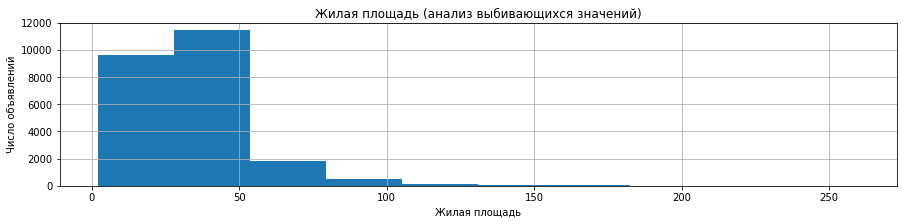

In [ ]:
df['living_area'].plot(kind='hist', grid=True, figsize=(15, 3))
plt.title('Жилая площадь (анализ выбивающихся значений)')
plt.xlabel('Жилая площадь')
plt.ylabel('Число объявлений');

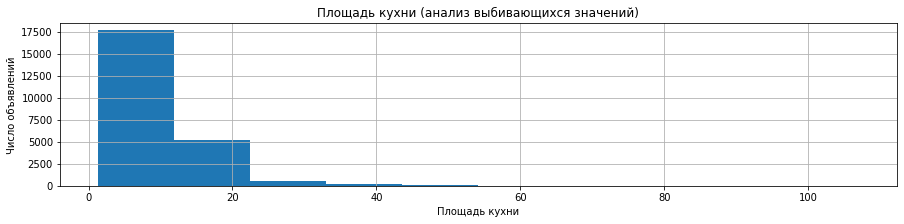

In [ ]:
df['kitchen_area'].plot(kind='hist', grid=True, figsize=(15, 3))
plt.title('Площадь кухни (анализ выбивающихся значений)')
plt.xlabel('Площадь кухни')
plt.ylabel('Число объявлений');

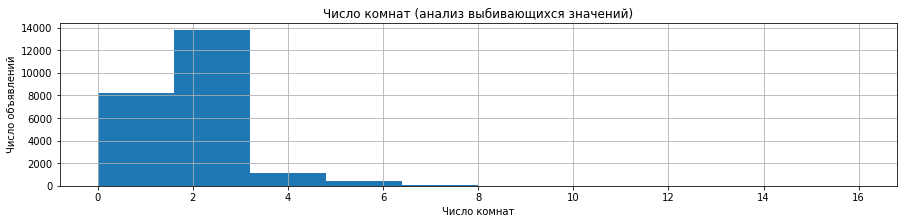

In [ ]:
df['rooms'].plot(kind='hist', grid=True, figsize=(15, 3))
plt.title('Число комнат (анализ выбивающихся значений)')
plt.xlabel('Число комнат')
plt.ylabel('Число объявлений');

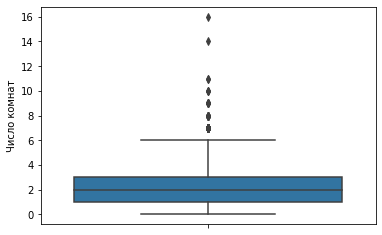

In [ ]:
sns.boxplot(y='rooms', data=df)
plt.ylabel('Число комнат');

16-комнатная квартира - вполне возможное явление, если речь идет о коммунальных квартирах, которых в Санкт-Петербурге немало. Но для нашего исследования это вброс. Ограничим его квартирами с восемью комнатами.

In [ ]:
df= df[df['rooms'] < 8].copy()

1. Вызывает настороженность информация в столбце с площадями кухонь. Есть несколько подозрительно больших цифр. Вполне возможно, что в части объявлений кухни объединены с гостиными. В таком случае указана их общая площадь. Либо сведения внесены наобум. Либо возникла ошибка при выгрузке. 
2. На гистограмме с жилой площадью также наблюдается жирный хвост. Его, как и площадь кухонь, мы решили оставить без изменений. Возможно, в строках с большой жилой площадью есть другая важная информация. Ограничимся фильтрацией по общей площади жилья и количеству комнат. 
3. В столбце с высотой потолков исправили ошибочно внесённые или неправильно выгруженные значения. Медианное значение после наших правок не изменилось. Среднее изменилось незначительно.
4. В столбце с ценой жилья убрали объекты недвижимости дороже 400 млн рублей. Медианные показатели и процентили остались без изменений и вполне соответствуют картине на рынке недвижимости.

<a id="new_column">
    
## Добавим в таблицу новые столбцы  </a>

In [ ]:
df['meter_price'] = df['last_price'] / df['total_area']
df['day_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month 
df['year_exposition'] = df['first_day_exposition'].dt.year

def sort_floors(row):
  floor = row['floor']
  home = row['floors_total']
  if floor == 1:
    return 'первый'
  if floor == row['floors_total']:
    return 'последний' 
  return 'другой'
df['floors_total_type'] = df.apply(sort_floors, axis=1)

df['km_city_centers'] = (df['city_centers_nearest'] / 1000).round()

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,day_exposition,month_exposition,year_exposition,floors_total_type,km_city_centers
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,...,482.00,2.00,755.00,"55,555.00","120,370.37",3,3,2019,другой,16.00
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,True,...,"55,555.00",0.00,NaN,81.00,"82,920.79",1,12,2018,первый,19.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,...,90.00,2.00,574.00,558.00,"92,785.71",3,8,2015,другой,14.00
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,91.18,9,True,...,84.00,3.00,234.00,424.00,"408,176.10",4,7,2015,другой,7.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,...,112.00,1.00,48.00,121.00,"100,000.00",1,6,2018,другой,8.00


In [ ]:
df.shape

(23627, 28)

После предобработки данных число строк уменьшилось на 214. Это 0,9% от первоначального значения. Вполне допустимо для дальнейшего анализа.

<a id="analys">
    
## Проведём исследовательский анализ данных </a>

<a id="basic">
    
**Изучим основные параметры объектов** </a>

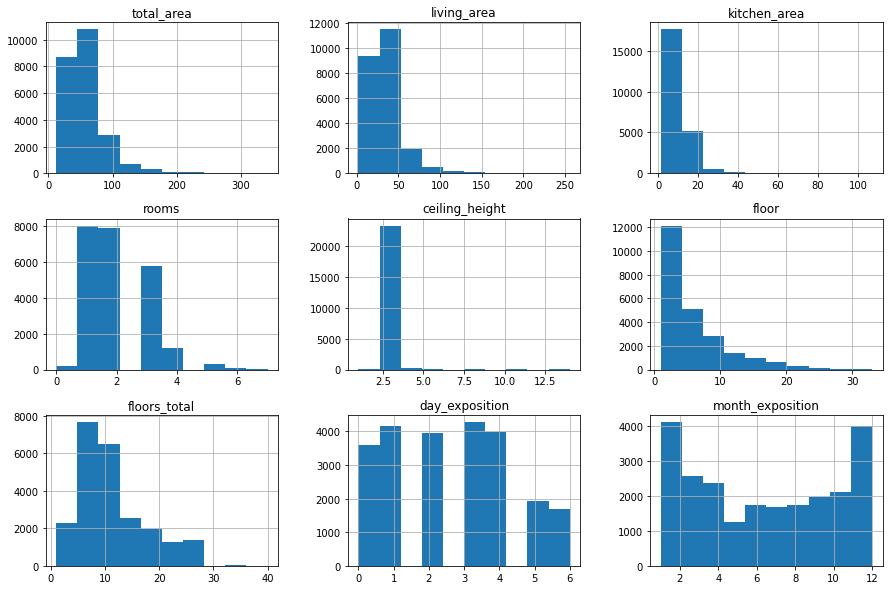

In [ ]:
df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'floor', 'floors_total_type', 'floors_total', 'day_exposition',
       'month_exposition']].hist(figsize=(15, 10));

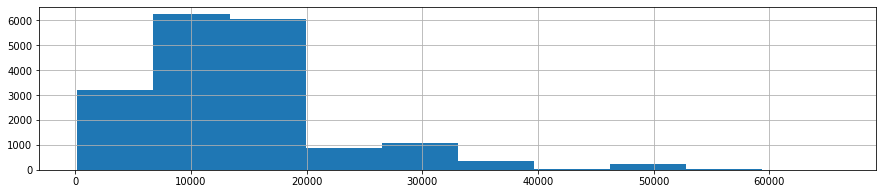

In [ ]:
def nearest(row):
    i = df[df[row] != 55555]
    i[row].hist(figsize=(15, 3));
nearest('city_centers_nearest')

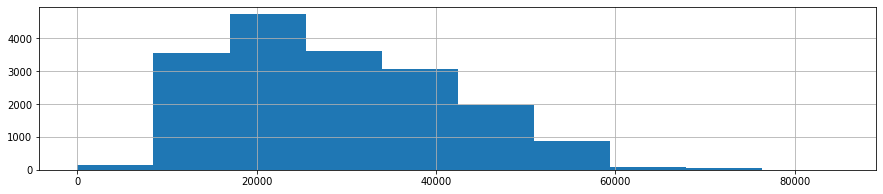

In [ ]:
nearest('airports_nearest')

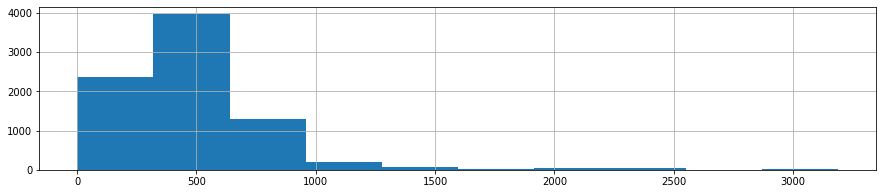

In [ ]:
nearest('parks_nearest')

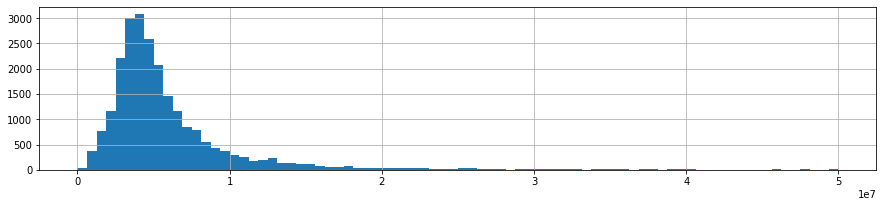

In [ ]:
df['last_price'].hist(bins=80, range=(0, 0.5e8), figsize=(15, 3));

1. Львиная доля объектов недвижимости в диапазоне общей площади от 40 до 70 квадратных метров. Даипазон жилой площади в большинстве объявлений - 19-40 квадратных метров. Площадь кухонь - 1-11 квадратных метров. Однако мы отмечали подозрительность значений в данном столбце. Резонно оценивать площадь кухни по медиане. 9 квадратных метров - вполне реалистичная площадь, если исходить из того, что площадь самых маленьких кухонь в домах=хрущевках около 5 квадратных метров.
2. Чаще всего продают одно- и двухкомнатные квартиры на первом-пятом этажах домов, высотой до 10 этажей.
3. Большинство выставленных на продажу объектов недвижимости расположены в пределах 20 километров от центра города. Скорее всего, речь идет о квартирах в Санкт-Петербурге. Более 15 тысяч объявлений именно из Санкт-Петербурга. Сопоставимое число объявлений о продаже квартир в пределах 20 километров от центра города. 
4. Чаще всего объявления публикуют в будние дни.
5. Пик публикаций приходится на декабрь и январь, конец и начало года. Минимум публикаций приходится на май. Летом число публикаций после мая незначительно вырастает, осенью еще немного подрастает. К началу зимы резкий рост. 
6. Стоимость большинства квартир в пределах 10 миллионов рублей с высокой концентрацией цен в диапазоне 3-6 миллионов рублей.  

<a id="speed">
    
**Изучим, как быстро продавались квартиры** </a>


In [ ]:
days_exp_norm = df[df['days_exposition'] < 55555] #избавимся от нашей заглушки, чтобы не мешала исследованию в этой категории.

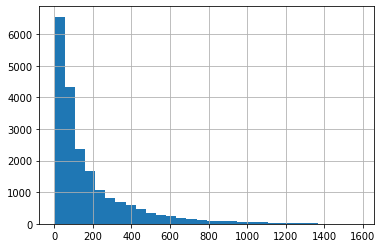

In [ ]:
days_exp_norm['days_exposition'].hist(bins=30);

In [ ]:
days_exp_norm['days_exposition'].describe()

count   20,464.00
mean       180.63
std        219.33
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64

Рассмотрим диапазон до 1 года подробнее, все-таки большинство квартир продается за этот период.

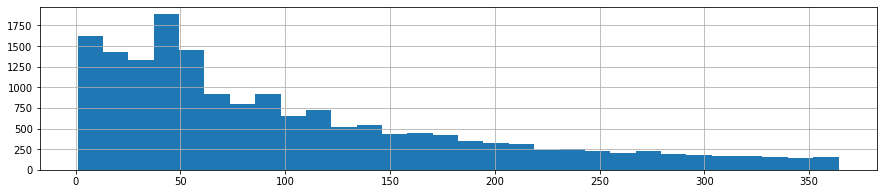

In [ ]:
for_year_exp_norm = df[df['days_exposition'] < 365]
for_year_exp_norm['days_exposition'].hist(bins=30, figsize=(15, 3));

Обычно продажа квартир занимает от трех месяцев до полугода. Но есть и быстрые продажи, когда покупатель находится за один день с момента публикации. К сверхъдолгим продажам можно отнести объявления, которые лежали на сайте два года, три и даже более четырёх лет. Среднее значение скорости продажи квартиры - 181 день. Медианное значение скорости продажи квартиры - 95 дней.

На гистаграмме, которая демонстрирует скорость продаж в диапазоне одного года, видно, что квартиры стараются продавать как можно быстрее. Максимальная концентрация продаж в первые 60 дней, после публикации объявления. Чем больше времени с момента публикации объявления проходит, тем меньше непроданных квартир остается.  

<a id="addiction">

**Изучим, от каких параметров зависит цена**
</a>


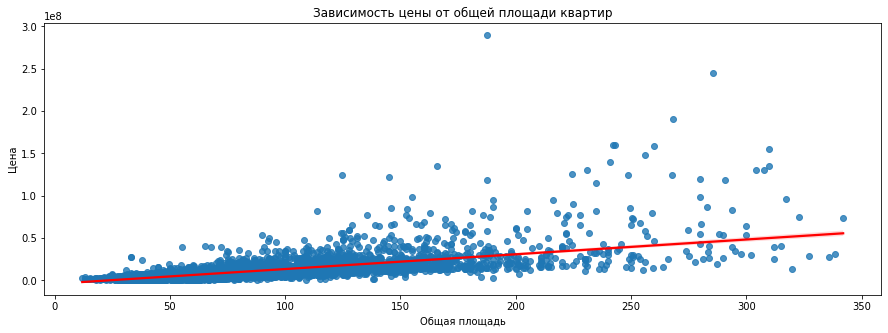

Коэффициент корреляции:  0.7013546010316838


In [ ]:
plt.figure(figsize = (15,5))
sns.regplot(x = 'total_area', y = 'last_price', data = df, line_kws={'color':'red'})
plt.title('Зависимость цены от общей площади квартир')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.show()

print('Коэффициент корреляции: ', df['last_price'].corr(df['total_area']))

In [ ]:
def connection(row):
  df.pivot_table(index=row, values='last_price', aggfunc='median').plot()

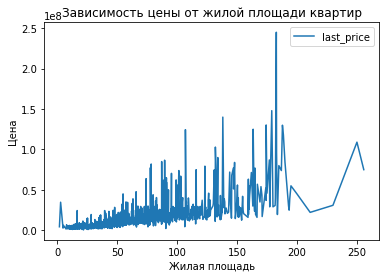

In [ ]:
connection('living_area')
plt.title('Зависимость цены от жилой площади квартир')
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.show()

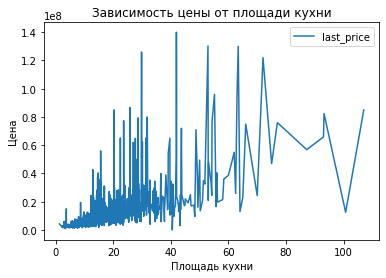

In [ ]:
connection('kitchen_area')
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.show()

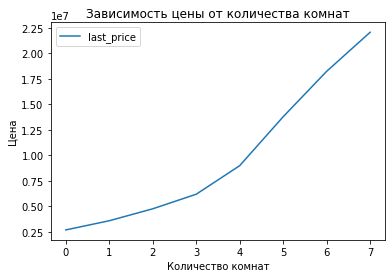

In [ ]:
connection('rooms')
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

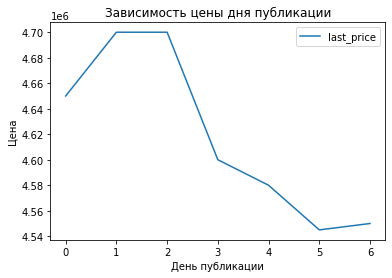

In [ ]:
connection('day_exposition')
plt.title('Зависимость цены дня публикации')
plt.xlabel('День публикации')
plt.ylabel('Цена')
plt.show()

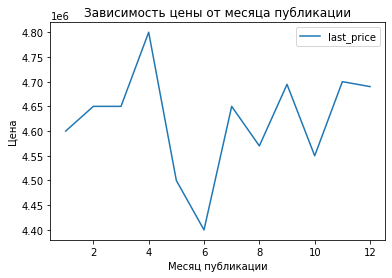

In [ ]:
connection('month_exposition')
plt.title('Зависимость цены от месяца публикации')
plt.xlabel('Месяц публикации')
plt.ylabel('Цена')
plt.show()

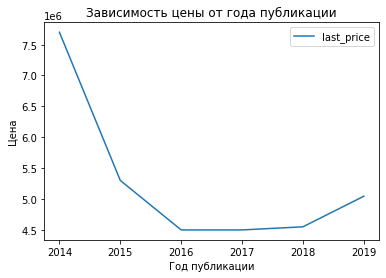

In [ ]:
connection('year_exposition')
plt.title('Зависимость цены от года публикации')
plt.xlabel('Год публикации')
plt.ylabel('Цена')
plt.show()

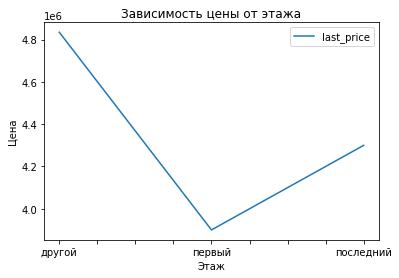

In [ ]:
connection('floors_total_type')
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.show()

In [ ]:
df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'day_exposition', 'month_exposition', 'year_exposition', 'floors_total_type', 'last_price']].corr() 

,total_area,living_area,kitchen_area,rooms,day_exposition,month_exposition,year_exposition,last_price
total_area,1.00,0.94,0.63,0.78,-0.01,0.01,-0.09,0.70
living_area,0.94,1.00,0.45,0.84,-0.01,0.00,-0.08,0.62
kitchen_area,0.63,0.45,1.00,0.30,-0.01,0.01,-0.06,0.56
rooms,0.78,0.84,0.30,1.00,-0.00,-0.00,-0.06,0.40
day_exposition,-0.01,-0.01,-0.01,-0.00,1.00,0.01,-0.01,-0.01
month_exposition,0.01,0.00,0.01,-0.00,0.01,1.00,-0.27,0.00
year_exposition,-0.09,-0.08,-0.06,-0.06,-0.01,-0.27,1.00,-0.05
last_price,0.70,0.62,0.56,0.40,-0.01,0.00,-0.05,1.00


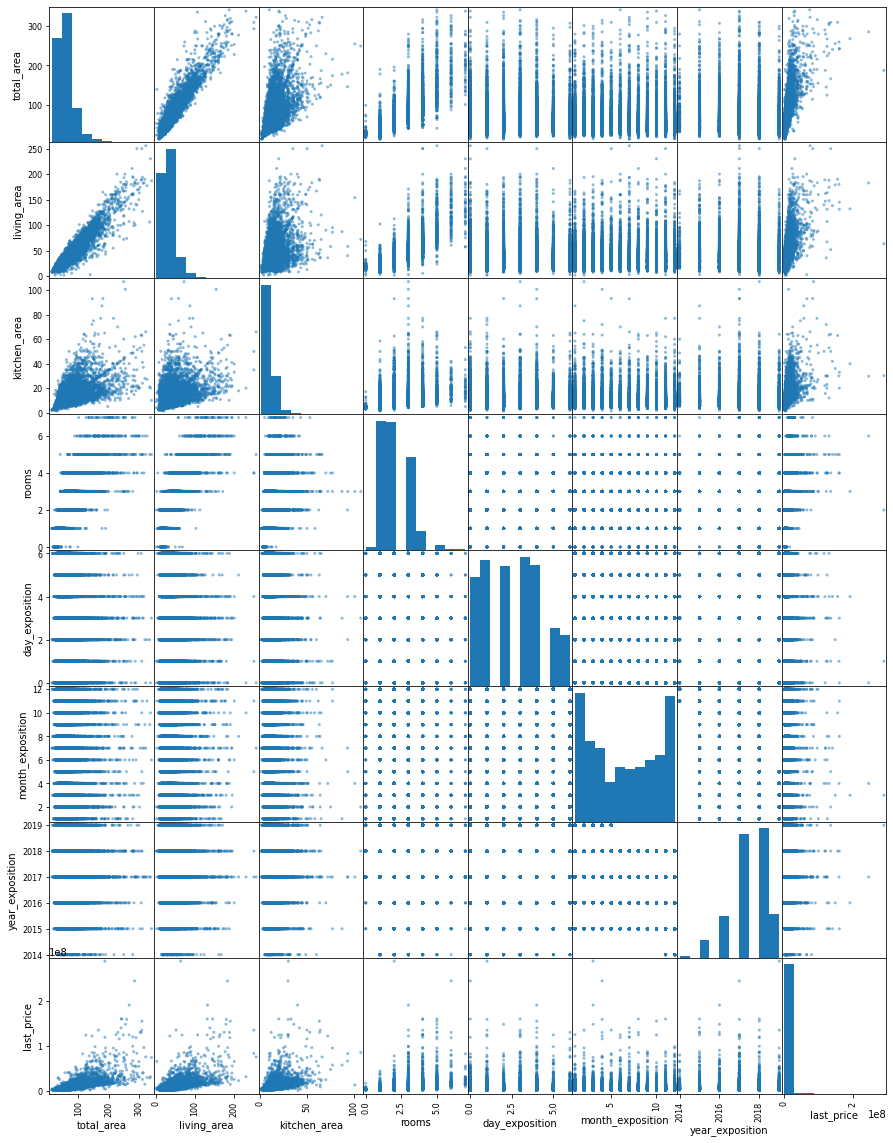

In [ ]:
pd.plotting.scatter_matrix(df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'day_exposition', 'month_exposition', 'year_exposition', 'floors_total_type', 'last_price']], figsize=(15, 20));

1. Вполне ожидаемо, что цена зависит от общей площади квартиры, жилой площади, площади кухни, количества комнат. Жильё на первом этаже стоит дешевле.
2. Из интересного - во вторник и среду выставляют самые дорогие квартиры. В субботу и воскресенье - самые дешевые. Самые дорогие предложения в году приходятся на апрель, самые низкие - на июнь. 
3. С 2014 по 2016 год произошло сильное снижение стоимости квадратного метра жилья. В 2016-2018 годах цены практически не менялись. Постепенный рост начался с 2018 года.

<a id="mean_meter">

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**
</a>


In [ ]:
locality_price = df.pivot_table(index='locality_name', values='meter_price', aggfunc=('count', 'mean'))
locality_price.columns=['Количество объявлений', 'Средняя цена за 1 кв. м']
locality_price.sort_values(by=['Количество объявлений', 'Средняя цена за 1 кв. м'], ascending=False).head(10)

,Количество объявлений,Средняя цена за 1 кв. м
locality_name,,
Санкт-Петербург,15653,"114,333.05"
посёлок Мурино,590,"86,087.51"
деревня Кудрово,472,"95,324.93"
посёлок Шушары,440,"78,677.36"
Всеволожск,398,"68,654.47"
Пушкин,367,"103,130.85"
Колпино,337,"75,333.30"
посёлок Парголово,327,"90,175.91"
Гатчина,307,"68,746.15"


In [ ]:
locality_price.sort_values(by='Средняя цена за 1 кв. м', ascending=False).head()

,Количество объявлений,Средняя цена за 1 кв. м
locality_name,,
Зеленогорск,24,"115,122.80"
Санкт-Петербург,15653,"114,333.05"
посёлок Репино,4,"104,238.61"
Пушкин,367,"103,130.85"
Сестрорецк,183,"101,757.62"


In [ ]:
locality_price.sort_values(by=['Количество объявлений', 'Средняя цена за 1 кв. м'], ascending=False).tail(5)

,Количество объявлений,Средняя цена за 1 кв. м
locality_name,,
посёлок станции Лужайка,1,"15,000.00"
деревня Сижно,1,"13,709.68"
посёлок Тёсово-4,1,"12,931.03"
деревня Малая Романовка,1,"12,724.55"
деревня Вахнова Кара,1,"11,688.31"


1. Самая высокая стоимость 1 квадратного метра в пригороде Санкт-Петербурга городе Зеленогорске (115123 рубля), однако в наличии 24 объявления в Зеленогорске. На втором месте по стоимости - Санкт-Петербург. 15667 объявлений и стоимость 1 квадратного метра - 114500 рублей. 
2. Самая низкая стоимость 1 квадратного метра в списке по количеству объявлений в деревне Вахнова Кара Ленинградской области (11688 рублей).

<a id="mean_price">

**Вычислим среднюю цену каждого километра в Санкт-Петербурге**
</a>



In [ ]:
sp_price_km = df[(df['locality_name'] == 'Санкт-Петербург') & (df['city_centers_nearest'] != 55555)] #исключим строки, где в расстоянии до центра стояла заглушка 55555
sp_price_km.groupby('km_city_centers')['meter_price'].mean()

km_city_centers
0.00    245,833.53
1.00    169,462.24
2.00    155,941.74
3.00    121,013.76
4.00    130,266.34
5.00    139,317.06
6.00    149,838.53
7.00    156,356.49
8.00    124,296.89
9.00    113,131.04
10.00   112,906.30
11.00   108,630.84
12.00   107,503.15
13.00   108,125.96
14.00   104,264.61
15.00   104,297.93
16.00   100,542.61
17.00    96,601.85
18.00    96,362.26
19.00    98,652.74
20.00   103,045.18
21.00    94,469.58
22.00    91,330.43
23.00    91,828.52
24.00    85,736.90
25.00    91,531.37
26.00    89,285.88
27.00   132,115.71
28.00    81,161.92
29.00    72,953.37
Name: meter_price, dtype: float64

In [ ]:
km_27 = sp_price_km[sp_price_km['km_city_centers'] == 27]
len(km_27)

2

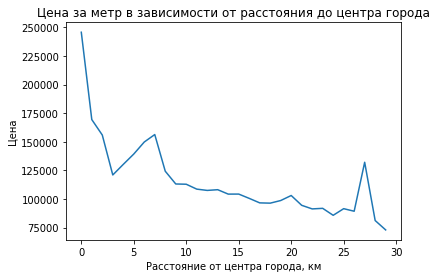

In [ ]:
sp_price_km.groupby('km_city_centers')['meter_price'].mean().plot();
plt.title('Цена за метр в зависимости от расстояния до центра города')
plt.xlabel('Расстояние от центра города, км')
plt.ylabel('Цена')
plt.show()

1. Почти с каждым километром от центра города цена за квадратный метр жилья постепенно снижается. Из общей тенденции выбивается 27-й километр, однако на таком расстоянии от центра сведения о продаже только двух объектов недвижимости, мало данных. 

<a id="conclusion">
    
## Общий вывод </a>

1. На рыночную стоимость влияет площадь квартиры, количество комнат, этаж. Жилье на первом этаже стоит дешевле. В ситуации с Санкт-Петербургом влияние оказывает еще и близость к центру города. Так, 1 квадратный метр в центре стоит в среднем 246 тысяч рублей, тогда как на окраине - 73 тысячи рублей. Самый дешевый объект недвижимости по количеству объявлений находится в деревне Вахнова Кара Ленинградской области. Стоимость квадратного метра там - 11688 рублей)
2. Стоимость большинства квартир в пределах 10 миллионов рублей с высокой концентрацией цен в диапазоне 3-6 миллионов рублей.  
3. В среднем на продажу квартиры уходит от 3 месяцев до полугода.
4. Чаще всего продают одно- и двухкомнатные квартиры на первом-пятом этажах домов, высотой до 10 этажей.
5. Пик публикаций приходится на декабрь и январь. Меньше всего новых объявлений появляется в мае. Самые дорогие предложения в году приходятся на апрель, самые дешёвые - на июнь. Во вторник и среду выставляют самые дорогие квартиры. В субботу и воскресенье - самые дешевые. 
6. С 2014 по 2016 год произошло сильное снижение стоимости квадратного метра жилья. В 2016-2018 годах цены практически не менялись. Постепенный рост начался с 2018 года.

Для улучшения сбора данных рекомендуем обратить внимание на точность работы картографических сервисов и корректность выгрузки столбцов с непрерывными переменными.